In [159]:
import numpy as np
import matplotlib.pyplot as plt

import itertools
import time
import os

import glob

from natsort import natsorted
from IPython.display import clear_output, display

from tqdm.auto import tqdm

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [160]:
fblocks = np.array([
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(4,0,0)],
    [(0,0,0),(1,0,1),(2,0,0),(2,-1,1),(1,1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(0,1,1),(2,-1,1)],
    [(0,0,0),(1,0,1),(2,0,0),(-1,0,1),(0,-1,1)],
    [(0,0,0),(-1,0,1),(1,0,1),(0,1,1),(0,-1,1)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,-1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(0,1,1)],
    [(0,0,0),(0,1,1),(2,0,0),(2,1,1),(1,1,0)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,2,1)],
    [(0,0,1),(-1,0,0),(0,1,0),(1,1,1),(2,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0),(-1,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0)],
    [(0,0,0),(1,1,0),(2,2,0),(0,1,1),(1,2,1)]
])


board_size = 8

#fblocks = np.array([
#    [(0,0,0)],
#    [(0,0,0),(-1,0,1),(0,-1,1)],
#    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
#    [(0,0,0),(-1,0,1),(0,-1,1),(0,-2,0)],
#    [(0,0,1),(-1,0,0),(0,-1,0),(0,-2,1)],
#    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
#    [(0,0,0),(0,1,1),(0,2,0)],
#    [(0,0,1),(0,1,0)]
#])
#
#board_size = 5

blocks = []
for block in fblocks:
    blocks.append(np.array(block))
fblocks = np.array(blocks).copy()

dcol = np.random.rand(len(fblocks),3)

In [161]:
def rot_mat(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.round(np.array(((c,-s), (s, c))))
    return R

def rotation(block, rot=0):
    block = block.copy()
    angles = [0,90,180,270]
    rblock = block[...,:-1]
    rblock = np.array(list(map(lambda x : np.matmul(rot_mat(angles[rot]), x), rblock))).astype(int)
    block[...,:-1] = rblock
    return block

def translation(block, vector):
    block = block.copy()
    rblock = block[...,:-1]
    rblock = np.array(list(map(lambda x : x + vector, rblock)))
    block[...,:-1] = rblock
    return block

def mirroring(block, mirror):
    block = block.copy()
    rblock = block[...,:-1]
    if mirror:
        rblock = np.array(list(map(lambda x : x * (-1), rblock)))
    block[...,:-1] = rblock
    return block

In [162]:
def move_block(block, setting):
    block = mirroring(block,setting[-1])
    block = rotation(block,setting[-2])
    block = translation(block,setting[:-2])
    return block

def move_blocks(gnome):
    moved = [move_block(block, all_combs[gene]) for (block, gene) in zip(fblocks, gnome)]
    return moved

def plot_block(block, setting = [0,0,0,0], *args, **kwargs):
    block = move_block(block, setting)
    mask = block[...,-1] == 0
    plt.plot(block[mask,0], block[mask,1], marker='s', fillstyle='top', linewidth=0, *args, **kwargs)
    plt.plot(block[~mask,0], block[~mask,1], marker='s', fillstyle='bottom', linewidth=0, *args, **kwargs)
    
def plot_blocks(blocks, settings = None, filename = None, *args, **kwargs):
    fig = plt.figure(figsize=(10,10))
    edges = np.array([[0,0], [0,board_size-1], [board_size-1,board_size-1], [board_size-1,0], [0,0]])
    plt.plot(edges[:,0], edges[:,1], color='r')
    for idx,block in enumerate(blocks):
        setting = [0,0,0,0] if settings is None else settings[idx]
        plot_block(block, setting, markersize=40, color = dcol[idx])
    plt.xlim(-1, board_size)
    plt.ylim(-1, board_size)
    
    if filename is not None:
        plt.savefig(f'images/{filename}', bbox_inches='tight', dpi=100)
        plt.close(fig)

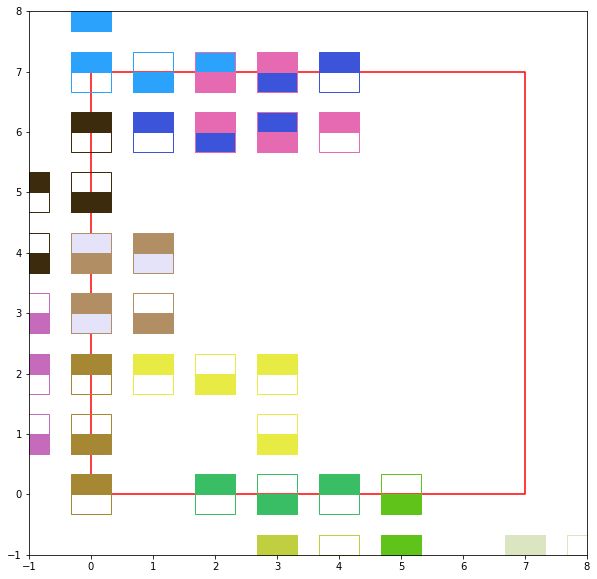

In [163]:
vecs = [np.random.randint(-1,board_size,2) for i in range(len(fblocks))]
rots = [np.random.randint(0,4) for i in range(len(fblocks))]
mirrs = [np.random.randint(0,1) for i in range(len(fblocks))]

settings = [(*vec, rot, mirr) for vec,rot,mirr in zip(vecs,rots,mirrs)]

plot_blocks(fblocks, settings)

In [164]:
# brute force it
brute_positions_x = np.array(list(range(board_size)))
brute_positions_y = brute_positions_x
brute_rotations = np.array(list(range(4)))
brute_mirrors = np.array(list(range(2)))

iterables = [brute_positions_x, brute_positions_y, brute_rotations, brute_mirrors]

all_combs = np.array(list(itertools.product(*iterables)))

In [165]:
def board_count(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks, axis=0)
    
    edges = [any(coord < 0 for coord in block) or any(coord >= board_size for coord in block) for block in flats]
    return np.count_nonzero(edges)
    

def duplication_count(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks)
    mat = np.zeros((board_size, board_size))
    for pos in flats:
        x, y = pos
        if x < 0 or x >= board_size or y < 0 or y >= board_size:
            continue
        mat[pos[0]][pos[1]] += 1
        
    nflats = mat.ravel()
    dcount = 0
    for n in nflats:
        if n > 1:
            dcount += n
            
    return int(dcount)

def single_check(case):
        if np.sum(case[:-1]) % 2 != case[-1]:
            return False
        return True

def fillstyle_count(blocks):
    flats = np.concatenate(blocks, axis=0)
    dcount = 0
    for case in flats:
        if not single_check(case):
            dcount += 1
    return dcount

def fitness_function(blocks):
    return board_count(blocks)**2 + duplication_count(blocks)**3 + fillstyle_count(blocks)

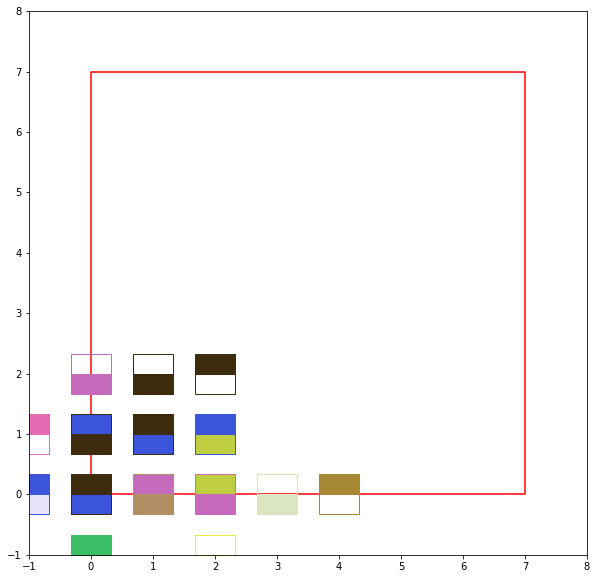

In [166]:
plot_blocks(fblocks)

In [172]:
# Number of individuals in each generation 
POPULATION_SIZE = 100

# Valid genes 
GENES = list(range(len(all_combs)))

class Individual(object): 
    ''' 
    Class representing individual in population 
    '''
    def __init__(self, chromosome): 
        self.chromosome = np.array(chromosome )
        self.fitness = self.cal_fitness() 

    @classmethod
    def mutated_genes(self): 
        ''' 
        create random genes for mutation 
        '''
        global GENES 
        gene = np.random.choice(GENES) 
        return gene 

    @classmethod
    def create_gnome(self): 
        ''' 
        create chromosome or string of genes 
        '''
        global fblocks 
        gnome_len = len(fblocks) 
        return np.array([self.mutated_genes() for _ in range(gnome_len)])
    
    @staticmethod
    def swap_genes(chromosome, pair_swap):
        '''
        switch two genes in the chromosome
        '''
        gnome = chromosome.copy()
        gnome[pair_swap] = gnome[np.flip(pair_swap)]
        return gnome        

    def mate(self, par2): 
        ''' 
        Perform mating and produce new offspring 
        '''
        global fblocks
        # chromosome for offspring 
        child_chromosome = [] 
        for gp1, gp2 in zip(self.chromosome, par2.chromosome):
            # random probability 
            prob = np.random.rand()
            child_chromosome = list(child_chromosome)

            # if prob is less than 0.45, insert gene 
            # from parent 1 
            if prob < 0.45: 
                child_chromosome.append(gp1) 

            # if prob is between 0.45 and 0.90, insert 
            # gene from parent 2 
            elif prob < 0.9: 
                child_chromosome.append(gp2) 
                
            # otherwise insert random gene(mutate), 
            # for maintaining diversity 
            else: 
                child_chromosome.append(self.mutated_genes()) 
                
            child_chromosome = np.array(child_chromosome)
                
        # do random swap of genes
        for _ in range(int(np.random.exponential(2))):
            swap_pair = np.random.randint(0, len(fblocks), 2)
            child_chromosome = self.swap_genes(child_chromosome, swap_pair)

        # create new Individual(offspring) using 
        # generated chromosome for offspring 
        return Individual(child_chromosome) 

    def cal_fitness(self): 
        ''' 
        Calculate fittness score, it is the number of 
        characters in string which differ from target 
        string. 
        '''
        global TARGET
        
        fitness = 0
        
        blocks = move_blocks(self.chromosome)
        return fitness_function(blocks)

In [173]:
# Driver code 
def main(): 
    global POPULATION_SIZE 

    #current generation 
    generation = 1
    finalfit = -999

    found = False
    population = [Individual(Individual.create_gnome()) for i in range(POPULATION_SIZE)] 

    while not found: 

        # sort the population in increasing order of fitness score 
        population = sorted(population, key = lambda x:x.fitness) 

        # if the individual having lowest fitness score ie. 
        # 0 then we know that we have reached to the target 
        # and break the loop 
        if population[0].fitness <= 0: 
            found = True
            break

        # Otherwise generate new offsprings for new generation 
        new_generation = [] 

        # Perform Elitism, that mean 10% of fittest population 
        # goes to the next generation 
        s = int((10*POPULATION_SIZE)/100) 
        new_generation.extend(population[:s]) 

        # From 50% of fittest population, Individuals 
        # will mate to produce offspring 
        s = int((90*POPULATION_SIZE)/100) 
        for _ in range(s): 
            parent1 = np.random.choice(population[:50]) 
            parent2 = np.random.choice(population[:50]) 
            child = parent1.mate(parent2) 
            new_generation.append(child) 

        population = new_generation 

        if generation % 10 == 0:
            print("Generation: {}\tChromosome: {}\tFitness: {}".format(generation, ','.join([str(x) for x in population[0].chromosome]), population[0].fitness), flush=True) 

        generation += 1
        finalfit = population[0].fitness
        
        #if generation > 100:
        #    generation = 1
        #    population = [Individual(Individual.create_gnome()) for i in range(POPULATION_SIZE)] 


    print("Generation: {}\tChromosome: {}\tFitness: {}".format(generation, ','.join([str(x) for x in population[0].chromosome]), population[0].fitness))
    return population

In [174]:
result = main()

Generation: 10	Chromosome: 323,464,120,499,79,57,150,417,442,100,456,163,2	Fitness: 715
Generation: 20	Chromosome: 323,283,120,499,79,57,232,417,442,100,456,163,2	Fitness: 520
Generation: 30	Chromosome: 323,283,120,499,79,57,232,417,442,100,456,163,2	Fitness: 520
Generation: 40	Chromosome: 323,283,120,499,79,57,232,417,442,100,456,163,2	Fitness: 520
Generation: 50	Chromosome: 323,283,120,499,79,57,232,417,442,100,456,163,2	Fitness: 520
Generation: 60	Chromosome: 323,442,232,61,79,477,194,417,442,100,499,275,2	Fitness: 479
Generation: 70	Chromosome: 323,509,232,456,79,477,194,417,442,100,313,275,2	Fitness: 445
Generation: 80	Chromosome: 323,436,232,61,79,477,194,417,275,494,323,442,2	Fitness: 427
Generation: 90	Chromosome: 323,442,120,499,79,57,194,417,442,100,456,275,226	Fitness: 378
Generation: 100	Chromosome: 323,442,120,499,79,57,194,417,442,100,456,275,226	Fitness: 378
Generation: 110	Chromosome: 323,442,120,499,79,57,194,417,442,100,456,275,226	Fitness: 378
Generation: 120	Chromos

KeyboardInterrupt: 

In [146]:
result[0].chromosome

[119, 150, 3, 181, 60, 135, 16, 184]

In [147]:
fitness_function(move_blocks(result[0].chromosome))

0

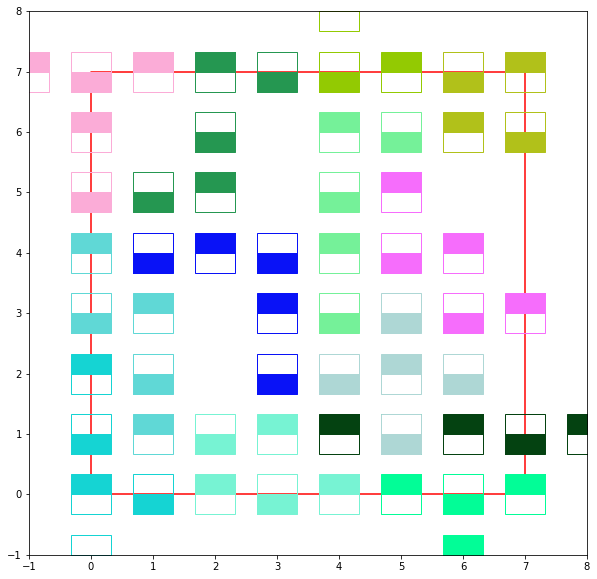

In [169]:
#plot_blocks(move_blocks(result[0].chromosome))
plot_blocks(move_blocks([269,449,187,2,337,59,307,383,228,27,201,508,479]))